In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import os

import json

from minima_volume.volume_funcs import ( load_data_files, process_wiggle_results, extract_data)

def plot_histogram(categories: list,
                   metric_values: list,
                   metric_name: str = "Metric",
                   loss_threshold: float = None,
                   save_path: str = None,
                   display: bool = True,
                   problem_name: str = None,
                   xlabel_size: int = 15,
                   ylabel_size: int = 15,
                   title_size: int = 17,
                   legend_size: int = 12,
                   xlim: tuple = None,
                   ylim: tuple = None,
                   xticks: list = None,
                   yticks: list = None,
                   tick_size: int = 12,
                   legend_loc: str = "best") -> None:
    """
    Plot overlapping histograms for different categories with max-value markers.
    Extremes (smallest and largest category) are emphasized with higher opacity.

    Args:
        categories (list): List of category labels (e.g., [100, 200, 300] examples trained on)
        metric_values (list): List of arrays/lists of values for each category
        metric_name (str): Label for x-axis
        loss_threshold (float, optional): Threshold used in processing (for title)
        save_path (str, optional): Path to save the figure
        display (bool): Whether to display the figure
        problem_name (str, optional): Name of the dataset/problem (e.g. "MNIST") for title
        xlabel_size, ylabel_size, title_size, legend_size (int): Font sizes
        xlim, ylim (tuple): Axis limits (min, max)
        xticks, yticks (list): Explicit tick locations
        tick_size (int): Tick mark font size
        legend_loc (str): Legend location
    """
    if len(categories) != len(metric_values):
        raise ValueError("categories and metric_values must have the same length")

    valid_data = [(cat, np.array(vals)) for cat, vals in zip(categories, metric_values) if len(vals) > 0]
    if not valid_data:
        raise ValueError("No valid metric values to plot")

    valid_data.sort(key=lambda x: x[0])

    all_metrics = np.concatenate([vals for _, vals in valid_data])
    bins = np.linspace(all_metrics.min(), all_metrics.max(), 17)

    cmap = plt.cm.tab10
    colors = [cmap(i % 10) for i in range(len(valid_data))]

    plt.figure(figsize=(8, 5.5), constrained_layout=True)
    for idx, ((cat, vals), color) in enumerate(zip(valid_data, colors)):
        alpha_val = 0.8 if idx == 0 or idx == len(valid_data) - 1 else 0.4
        plt.hist(vals, bins=bins, alpha=alpha_val, density=True,
                 label=f"Minima Trained On {cat:,} Examples",
                 color=color, edgecolor="black", linewidth=1.5)
        max_val = np.max(vals)
        plt.axvline(max_val, color=color, linestyle="--", linewidth=3.0,
                    label=f"Max Perturbation Radius: {max_val:.2f}")

    plt.xlabel(metric_name, fontsize=xlabel_size)
    plt.ylabel("Density", fontsize=ylabel_size)
    title = f"{problem_name + ' ' if problem_name else ''}Perturbation Radii\nLoss Threshold: {loss_threshold}"
    plt.title(title, fontsize=title_size)

    # Set axis limits if provided
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    # Set tick locations and fontsize
    if xticks is not None:
        plt.xticks(xticks, fontsize=tick_size)
    else:
        plt.xticks(fontsize=tick_size)
    if yticks is not None:
        plt.yticks(yticks, fontsize=tick_size)
    else:
        plt.yticks(fontsize=tick_size)

    plt.legend(fontsize=legend_size, loc=legend_loc)
    plt.grid(alpha=0.3)

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches="tight")
        print(f"Plot saved to: {save_path}")

    if display:
        plt.show()
    else:
        plt.close()

def process_histogram(directory,
                      loss_threshold,
                      max_perturbs=None,
                      plot_data_indices=None,
                      problem_name=None,
                      # New plotting parameters
                      xlabel_size=15,
                      ylabel_size=15,
                      title_size=17,
                      legend_size=12,
                      xlim=None,
                      ylim=None,
                      xticks=None,
                      yticks=None,
                      tick_size=12,
                      legend_loc="best"):
    """
    Process wiggle results and plot perturbation radius distributions by data level.

    Args:
        directory (str): Directory path where input .npz files are stored.
        loss_threshold (float): Threshold for processing wiggle loss results.
        max_perturbs (int, optional): Maximum number of perturbations to consider.
        plot_data_indices (list of int, optional): Indices of model data levels to plot.
        problem_name (str, optional): Name of the dataset/problem (e.g. "MNIST") for title.
        xlabel_size, ylabel_size, title_size, legend_size (int): Font sizes.
        xlim, ylim (tuple): Axis limits.
        xticks, yticks (list): Explicit tick locations.
        tick_size (int): Tick mark font size.
        legend_loc (str): Legend location.
    """
    # --- collect all .npz files ---
    files_to_load = [f for f in os.listdir(directory) if f.endswith(".npz")]
    data_dictionary = load_data_files(files_to_load, directory=directory)

    model_key = list(data_dictionary.keys())[0]
    base_dataset_size = data_dictionary[model_key]['base_dataset_size']

    processed_full_data = process_wiggle_results(data_dictionary, threshold=loss_threshold)

    model_data_levels, radii_list = extract_data(
        data_dict=processed_full_data,
        x_axis_key='model_trained_data',
        y_axis_key='r_vals'
    )

    model_data_levels = [lvl + base_dataset_size for lvl in model_data_levels]

    # Sort levels and radii
    sorted_pairs = sorted(zip(model_data_levels, radii_list), key=lambda x: x[0])
    model_data_levels, radii_list = zip(*sorted_pairs)
    model_data_levels, radii_list = list(model_data_levels), list(radii_list)

    if plot_data_indices is not None:
        model_data_levels = [model_data_levels[i] for i in plot_data_indices]
        radii_list = [radii_list[i] for i in plot_data_indices]

    print("Plotting levels:", model_data_levels)

    save_path = os.path.join(directory, f"radii_{problem_name}_loss_{loss_threshold}.png")
    plot_histogram(
        categories=model_data_levels,
        metric_values=radii_list,
        metric_name="Perturbation Radius",
        loss_threshold=loss_threshold,
        save_path=save_path,
        display=True,
        problem_name=problem_name,
        xlabel_size=xlabel_size,
        ylabel_size=ylabel_size,
        title_size=title_size,
        legend_size=legend_size,
        xlim=xlim,
        ylim=ylim,
        xticks=xticks,
        yticks=yticks,
        tick_size=tick_size,
        legend_loc=legend_loc
    )

    return {
        "model_data_levels": model_data_levels,
        "radii_list": radii_list
    }


Directories to analyze: ['data_0']

Analyzing directory: data_0 (Swiss Roll)
Plotting levels: [20, 800, 100]
Plot saved to: data_0\radii_Swiss Roll_loss_0.1.png


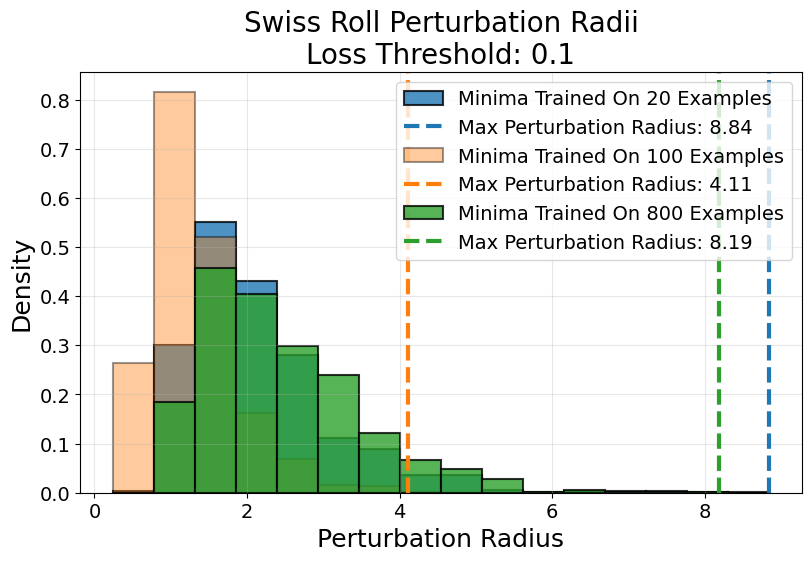

Plotting levels: [20, 800, 100]
Plot saved to: data_0\radii_Swiss Roll_loss_0.05.png


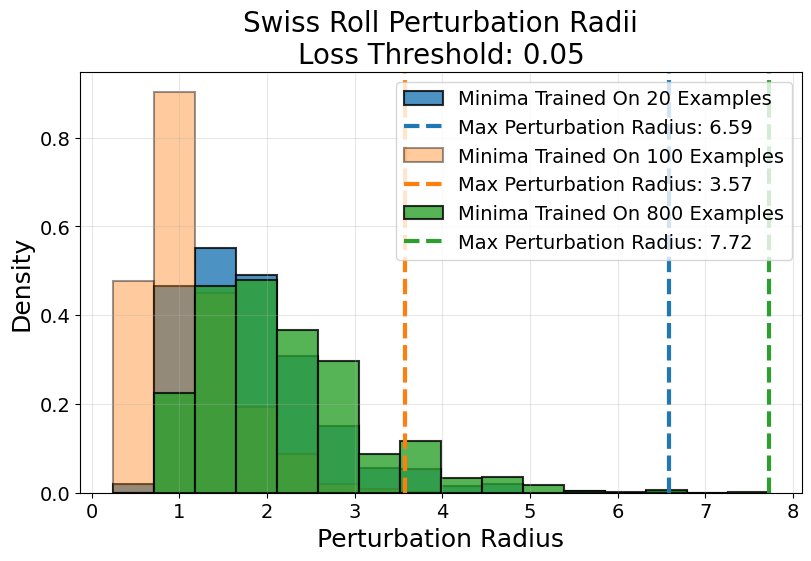

Plotting levels: [20, 800, 100]
Plot saved to: data_0\radii_Swiss Roll_loss_0.01.png


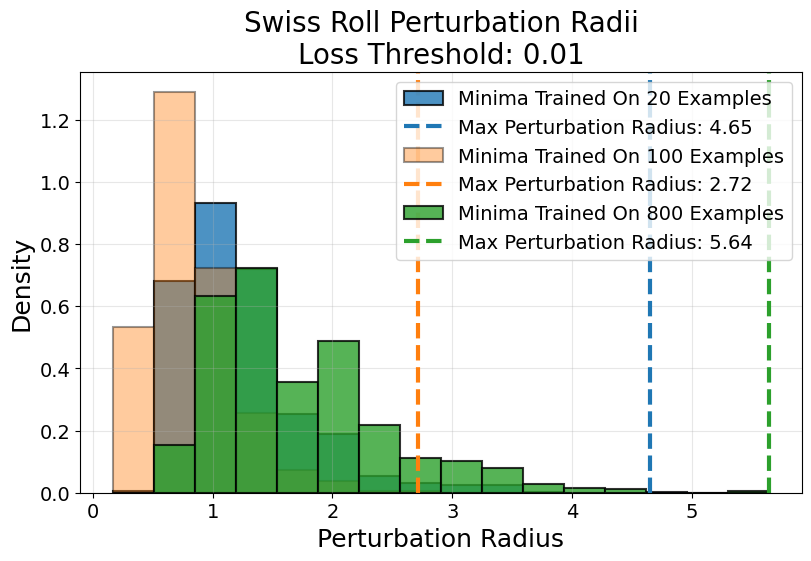

In [4]:
# Define thresholds as pairs
loss_thresholds = [0.1, 0.05, 0.01]
plot_indices = [0, 5, 2]

directories_to_analyze = ['data_0']
problem_names = ["Swiss Roll"]

print("Directories to analyze:", directories_to_analyze)

# Enumerate through directories and problem names together
for idx, (directory, problem_name) in enumerate(zip(directories_to_analyze, problem_names)):
    print(f"\n{'='*50}")
    print(f"Analyzing directory: {directory} ({problem_name})")
    print(f"{'='*50}")

    # Loop through the loss thresholds
    for loss_threshold in loss_thresholds:
        process_histogram(
            directory=directory,
            loss_threshold=loss_threshold,
            plot_data_indices=plot_indices,
            problem_name=problem_name,
            xlabel_size=18,
            ylabel_size=18,
            title_size=20,
            legend_size=14,
            #xlim=(0, 2),
            #ylim=(0, 2.5),
            #xticks=[0, 0.5, 1, 1.5, 2],
            #yticks=[0, 0.5, 1, 1.5, 2, 2.5],
            tick_size=14,
            legend_loc="upper right"
        )


Plotting levels: [20, 800, 100]
Plot saved to: data_0\radii_Swiss Roll_loss_0.1.png


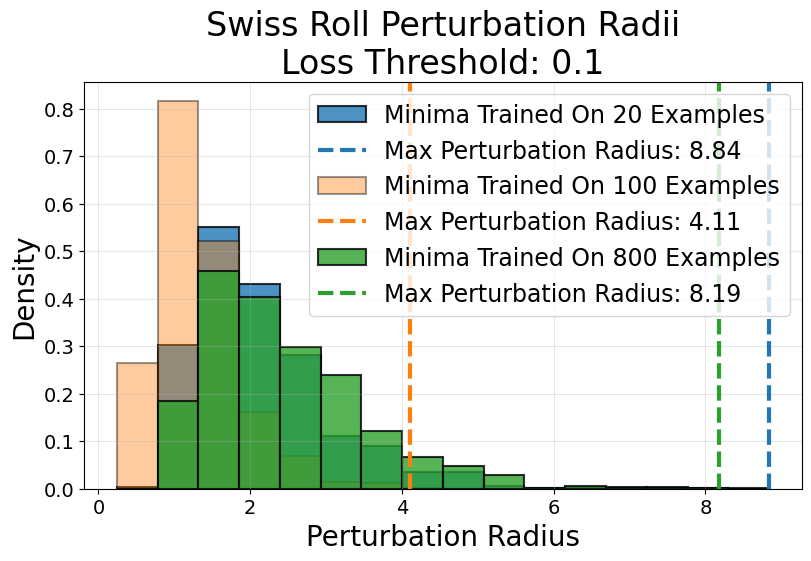

Plotting levels: [20, 800, 100]
Plot saved to: data_0\radii_Swiss Roll_loss_0.01.png


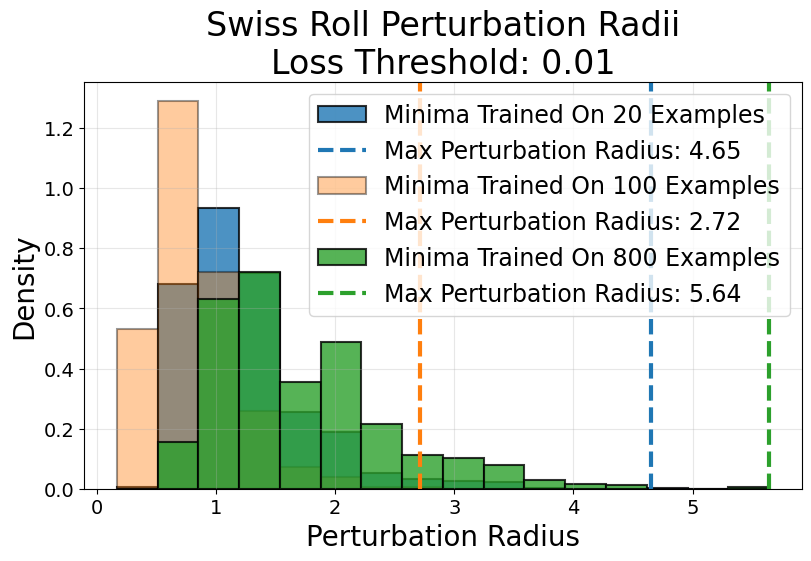

{'model_data_levels': [20, 800, 100],
 'radii_list': [[0.6760228934208724,
   0.6685592266822663,
   1.3320849897082812,
   1.3219872957199845,
   1.6821196896362618,
   0.8160509651089892,
   1.9608366948440974,
   0.5434516717579739,
   0.8052211808569638,
   0.9786991227975782,
   0.8182910872094425,
   1.6936612813743497,
   0.8271990175600406,
   0.978909186861513,
   0.6759564154805634,
   0.9492694164657944,
   1.5069085813860372,
   1.3260516698062943,
   1.1335378373816192,
   0.9732080885201447,
   0.812566027229215,
   1.4900762734881665,
   1.5008956166557264,
   1.1518185478049316,
   1.1331871125348043,
   0.9758576532369148,
   0.974597156759355,
   0.9708584872159092,
   0.673888749145097,
   1.521498309679268,
   0.818181261604215,
   0.9597407849804868,
   1.3209905407402232,
   0.8129394908010225,
   1.4984444372143848,
   1.3031571248808322,
   0.9560009944975323,
   1.3320985686449411,
   1.309586522530785,
   1.30272885437292,
   0.5492455979024083,
   1.136808682

In [5]:
# Finetuning plots

# Loss threshold 0.1
process_histogram(
    directory=directory,
    loss_threshold=0.1,
    plot_data_indices=plot_indices,
    problem_name=problem_name,
    xlabel_size=20,
    ylabel_size=20,
    title_size=24,
    legend_size=17,
    #xlim=(0, 58),
    #ylim=(0, 0.24),
    #xticks=[0, 10, 20, 30, 40, 50],
    #yticks=[0, 0.05, 0.1, 0.15, 0.2],
    tick_size=14,
    legend_loc="upper right"
)

# Loss threshold 0.01
process_histogram(
    directory=directory,
    loss_threshold=0.01,
    plot_data_indices=plot_indices,
    problem_name=problem_name,
    xlabel_size=20,
    ylabel_size=20,
    title_size=24,
    legend_size=17,
    #xlim=(0, 48),
    #ylim=(0, 0.24),
    #xticks=[0, 10, 20, 30, 40],
    #yticks=[0, 0.05, 0.1, 0.15, 0.2],
    tick_size=14,
    legend_loc="upper right"
)